In [1]:
import sys
sys.path.append('..')
from src.data.docx  import read_docx,process_docx,find_content
import glob
import json
import os
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore")
from src.models.pipeline import pipeline
from src.features.segment_transcript import CreateBlocks
from functools import reduce
import heapq
from gensim.corpora import Dictionary
from gensim import models
from gensim import similarities
import re
import statistics
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, HTML
from scipy.stats import entropy

# READ BOOKS OF VIDEOS

In [2]:
'''Defining CONSTS'''
docx_path = '../data/raw/docx'
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')
lemmatizing_method ='lemma' #'stemm'

In [3]:
videos_ids = list(map(lambda fl: fl.split('\\')[-1].split('.')[0],glob.glob(docx_path + '/*')))

In [4]:
desired_videos =['zWg7U0OEAoE']#['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ','zWg7U0OEAoE','tORLeHHtazM'] #['zWg7U0OEAoE','tORLeHHtazM'] #['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ']
videos_ids = list(filter(lambda x: x in desired_videos,videos_ids))

In [5]:
#video_docx = [glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0] for vid in videos_ids]
#docx_db =[read_docx(path) for path in video_docx]

In [6]:
f_read = {
    'statbook':'statbook',
    'Dsa':'Dsa'
}

docxs_chapter_keyword = {
    'statbook':'Topic',
    'Dsa': 'Chapter'
}

In [7]:
video_to_paper = {}
paper_content ={}
for vid in videos_ids:
    doc_path = glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0]
    doc_name = doc_path.split('\\')[-1].split('.')[0]
    video_to_paper[vid] = doc_name    
    if doc_name not in paper_content.keys():    
        full_text,font_sizes = read_docx(doc_path)
        paper_content[doc_name] = find_content(f_read[doc_name],
                                               full_text,
                                               font_sizes,
                                               docxs_chapter_keyword[doc_name],
                                              lemmatizing=lemmatizing_method)

# RESTORE RESULTS FROM TRAINING

In [8]:
'''Select transcript for only wanted videos'''
transcript_filespath = list(filter(lambda x: x.split('\\')[-1].split('.')[0] in videos_ids,transcript_filespath))

'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript
#print(transcripts_jsons)

'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

''' Transfer topic shifts time to seconds units instead HH:MM:SS'''
def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec
for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])
    

'''Get parameters from training'''
df_results = pd.read_csv('../data/processed/bayesian_opt/phrases/lemmas_adv_propn.csv')
n_largest_res = 3
pipeline_results = df_results[df_results['video'].isin(videos_ids)]\
                .groupby('video')[['video','workflow','params','max_target']]\
                .apply(lambda grp: grp.nlargest(n_largest_res,'max_target')).values.tolist()

pipeline_results = pipeline_results[:-1]#this is for zWg7U0OEAoE

    
    
    
def boundryevaluation(curresults,ground_base,accurrcy_shift = 30):
        true_positive = 0
        false_negative = 0
        false_positive = 0 
        true_positive_list_debug = []
        #false_negative_list_debug = []
        false_positive_list_debug = []
        results = curresults[:]
        
        
        #print('curresults %s' %(curresults))
        #print('ground_base %s ' %(ground_base))
        
        for grb in ground_base:
            is_false_positive = True
            for res in results:     
                if abs(res - grb) < accurrcy_shift:
                    is_false_positive = False
                    true_positive_list_debug.append(res)
                    true_positive+=1
                    results.remove(res)
                    break   
            if is_false_positive:
                false_positive_list_debug.append(grb)
                false_positive+=1
                
        #print("TP: " + str(true_positive_list_debug))
        #print("FP: " + str(false_positive_list_debug))
        #print("FN: " + str(curresults))
        #print('true_positive : %s ' %(true_positive))
        false_negative = len(results) # make sure the true positive are removed from here 
        recall_rate = true_positive/(true_positive + false_negative )
        precision_rate = true_positive/(true_positive + false_positive)
        #print("TP: %s , FP: %s, FN: %s" %(true_positive,false_positive,false_negative))
        #print("precision rate : %s, recall rate : %s " % (precision_rate,recall_rate))
        return precision_rate

    


In [9]:
videos_division = {}

for vid in videos_ids:
    vid_words = None
    vid_shifts = None
    groundbase = [246,415,534,639,783,896,1062,1329,1481,1631,1818,2019,2304,2502,2720,2987,3172]
    transcripts = transcripts_jsons[vid]
    print(vid)
    print(groundbase)
    print(transcripts[-1])
    block_handler = CreateBlocks(transcripts)
    block_as_topics = block_handler.partion_by_timestamp(groundbase)
    vid_words = [list(blk) for blk in block_as_topics]
    groundbase.append('end')
    videos_division[vid] = {'topic_words':vid_words,'topic_shift':groundbase}

zWg7U0OEAoE
[246, 415, 534, 639, 783, 896, 1062, 1329, 1481, 1631, 1818, 2019, 2304, 2502, 2720, 2987, 3172]
{'text': 'and terminology that we be following with\nthis course.', 'start': 3175.91, 'duration': 34.75}


In [10]:
#videos_division

# EXTRACT MAIN CHAPTERS OF BOOKS AND ORAGANIZE THE PAPER AS DIFFERENT DOCUMENTS GROUPS

In [11]:
paper_content[doc_name].keys()

dict_keys(['corpus', 'titles', 'main titles'])

In [12]:
'''Find the following for each paper:
    1) main chapter title index. for example [10,15....]
    2) range of subsection within each main chapter . for example [(0,9),(11,14)...]
    
    '''

paper_mainchapter_indexes = {}
paper_sec_within_main_indexes = {}
paper_mains_as_one_doc = {}
paper_subsec_as_one_doc = {}

for doc_name in paper_content.keys():
    '''Find the main chapter indexes in the list of the overall titles'''
    mainchapter_indexes = [paper_content[doc_name]['titles'].index(ch_title)
                           for ch_title in paper_content[doc_name]['main titles']]
    '''Find the subsection indexes range within each main chapter '''
    subsec_mainchapter_indexes = [range(mainchapter_indexes[index],mainchapter_indexes[index + 1])
                                  for index in range(len(mainchapter_indexes) - 1)]
    subsec_mainchapter_indexes.append(range(mainchapter_indexes[-1],
                                            len(paper_content[doc_name]['titles'])))
    paper_mainchapter_indexes[doc_name] = mainchapter_indexes
    paper_sec_within_main_indexes[doc_name] = subsec_mainchapter_indexes
    
    
    '''Making each chapter as a one documents'''
    
    '''Union all the documents in a section into single document'''
    paper_subsec_as_one_doc[doc_name] = [list(reduce(lambda doc,acc:doc + acc,sec,[]))
                                         for sec in paper_content[doc_name]['corpus']]
    '''Union all the sub section in a main chapter into one document'''
    paper_mains_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                    paper_subsec_as_one_doc[doc_name][s_i]+acc,subsec_indexes,[]))
                                        for subsec_indexes in paper_sec_within_main_indexes[doc_name]]

In [13]:
#paper_subsec_as_one_doc['statbook'][0]

In [14]:
'''Debug'''
"""
print(paper_content['statbook']['main titles'])
print((paper_content['statbook']['titles']))
print(len(paper_content['statbook']['titles']))# 
print(len(paper_content['statbook']['corpus']))#members of each element:section corpus
print(len(paper_content['statbook']['corpus'][0]))#members of each element: documents
print(len(paper_content['statbook']['corpus'][0][0])) #of each element words
print(paper_sec_within_main_indexes['statbook'])


#debug
print(sum([len(paper_subsec_as_one_doc['statbook'][s]) for s in range(0,10)]))
print(len(paper_mains_as_one_doc['statbook'][0]))
print(len(paper_mains_as_one_doc['statbook']))



"""
"""#print(len(paper_subsec_as_one_doc['statbook']))
print((subsec_mainchapter_indexes))
print(len(paper_content['Dsa']['titles']))
print(len(paper_subsec_as_one_doc[doc_name]))
print(len(paper_sec_within_main_indexes[doc_name]))
print(paper_content['Dsa']['titles'][-1])
print(paper_subsec_as_one_doc[doc_name][-2])
"""
"""print(paper_content['Dsa']['main titles'][0])
print(len(paper_mains_as_one_doc['Dsa'][0][0]))
print((paper_mains_as_one_doc['Dsa'][0][0]))
#print(len(paper_sec_within_main_indexes['Dsa'][0][0]))
print(len(paper_subsec_as_one_doc['Dsa'][0]))
print((paper_subsec_as_one_doc['Dsa'][0][0]))
print(len(videos_division['tORLeHHtazM']['topic_words'][0][0]))
print((videos_division['tORLeHHtazM']['topic_words'][0][0]))"""

#paper_content['Dsa']['corpus']
print((paper_mains_as_one_doc['Dsa'][0][0]))

flnal


In [15]:
'''Find phrasers of books  '''
paper_phrasers = {}
for doc_name in paper_mains_as_one_doc.keys():
    paper_phrasers[doc_name] = list(set(reduce(lambda acc,x: acc+x,
                                      [[w for w in ch if '_' in w]
                                      for ch in paper_mains_as_one_doc[doc_name]])))

In [16]:
#paper_phrasers['Dsa']

# FIND CORRELATION BETWEEN MAIN CHAPTERES AND FOUNDED TOPICS IN THE VIDEO 

In [17]:
def find_top_words_of_topic(topic_words,chapter_titles=None):
    for tp_i,tp_words in enumerate(topic_words):
        #
        raw_text = ' '.join(tp_words)
        myvectorizer = CountVectorizer()
        mytf = myvectorizer.fit_transform([raw_text]).toarray()
        #print(mytf)
        maxes = heapq.nlargest(3,mytf[0])
        indexes = []
        for i,bal in enumerate(mytf[0]):
            if bal in maxes:
                indexes.append(i)
        ws = [myvectorizer.get_feature_names()[_] for i,_ in enumerate(indexes)]
        
        if chapter_titles is None:
            print('top words for topic %s are %s' %(tp_i,ws))
        else:
            print('top words for topic %s are %s' %(chapter_titles[tp_i],ws))

In [18]:
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import spacy
from nltk.stem import PorterStemmer
stop_words = stopwords.words('english')
nlp = spacy.load('en',disable=['parser','ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB','PROPN','ADV']#['NOUN', 'ADJ', 'VERB','ADV']#['NOUN', 'ADJ', 'VERB','PROPN']# #['NOUN', 'ADJ', 'VERB']
porter = PorterStemmer()

In [19]:
def emphasize_title(doc_name,book_chapters,titles,factor_enrich = 20,lemmatizing = "lemma"):
    chapters_enriched = book_chapters[:]
    
    for index,tl in enumerate(titles):
        tl_text_no_punc = simple_preprocess(tl,deacc=True) 
        tokenized_text_non_stop_words = [ word for word in tl_text_no_punc 
                                         if word not in stop_words]
        """text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
        tokenized_lemmas = nlp(text_non_stop_words)
        tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                            if token.pos_ in allowed_postags]"""
        
        if lemmatizing == "stemm":
            tokenized_lemmas = [porter.stem(w) for w in tokenized_text_non_stop_words]
        else:
            text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
            tokenized_lemmas = nlp(text_non_stop_words)
            tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                                if token.pos_ in allowed_postags]

        
        
        tokenized_lemmas_ph = '_'.join(tokenized_lemmas)#reduce(lambda acc,x: acc+x,
        #print('tokenized_lemmas_ph %s' %(tokenized_lemmas_ph))
        
        if tokenized_lemmas_ph in paper_phrasers[doc_name]:
            tokenized_lemmas =[tokenized_lemmas_ph]
        
        chapters_enriched[index] = chapters_enriched[index] + tokenized_lemmas * factor_enrich
    return chapters_enriched

In [20]:
def get_topic_chapter_corr_tfidf(paper_name,book_chapters,
                                 vid_topics_words,vid_topics_shift,
                                 dispaly_titles,to_df=False):
    raw_book_video = []
    for tp_vid in vid_topics_words:
        raw_book_video = raw_book_video + [tp_vid]
    
    for ch in book_chapters:
        raw_book_video = raw_book_video + [ch]

    # creating dictionary of all of the words in the corpus of the video and the paper
    #print(len(raw_book_video))
    dictionary = Dictionary(raw_book_video)
    #dictionary = Dictionary(book_chapters)
    
    #ch_dict = Dictionary(book_chapters)
    #vid_dict = Dictionary(vid_topics_words)
    
    the_dictionary = dictionary
    
    #whole_corpus = vid_topics_words + book_chapters
    #bgw_corpus = [dictionary.doc2bow(doc) for doc in whole_corpus]
    bgw_chapter = [the_dictionary.doc2bow(doc) for doc in book_chapters]
    bgw_vids = [the_dictionary.doc2bow(doc) for doc in vid_topics_words]
    
    '''Calculate the pivot '''
    _tmp =  [len(list(set([w for w in ch]))) for ch in book_chapters]
    book_pivot = sum(_tmp)/len(_tmp)
    _tmp = [len(list(set([w for w in ch]))) for ch in vid_topics_words]
    vid_pivot = sum(_tmp)/len(_tmp)
    
    tf_idf_model_ch = models.TfidfModel(bgw_chapter,
                                        dictionary=the_dictionary#,
                                        #pivot=book_pivot#,
                                        #slope=0.8,
                                        #smartirs='nnc'
                                       ) #,
    tf_idf_model_vid = models.TfidfModel(bgw_vids,
                                         dictionary=the_dictionary#,
                                         #pivot=vid_pivot#,
                                         #slope=0.4
                                        )#,smartirs='lfc'
    
    index_sim = similarities.SparseMatrixSimilarity(tf_idf_model_ch[bgw_chapter],
                                                    num_features=len(the_dictionary))
    
    correlation = [[s for s in index_sim[tf_idf_model_vid[doc]]] for doc in bgw_vids]
    #print(tf_idf_model[bgw_vids])
    
    # find the top n words in the topic (in the video)
    #print('$$$$$$$$$$$$$$top words of video topic$$$$$$$$$$$$$$')
    #find_top_words_of_topic(videos_division[vid]['topic_words'])
    #print('$$$$$$$$$$$$$$top words of book chapters$$$$$$$$$$$$$$')
    #find_top_words_of_topic(book_chapters,chapter_titles=dispaly_titles)
    
    
    
    # normalizing the correlation between each topic and chapter 
    for i_t in range(len(correlation)):
        sum_ = sum(correlation[i_t])
        for ch_index in range(len(correlation[i_t])):
            correlation[i_t][ch_index] = correlation[i_t][ch_index]/sum_
    
    corr_as_row = reduce(lambda x,y: x+y,correlation,[] ) # to get the global max in min
    sns.heatmap(correlation,vmin=min(corr_as_row),vmax=max(corr_as_row))
    plt.show()
    
    
    
    # find the cha
    ch_matching_top = []
    #print(len(correlation[0]))
    
    
    for i,corr in enumerate(correlation):
        max_cor = max(corr) # max correlation with that topic
        shift = vid_topics_shift[i]
        founded_title = dispaly_titles[corr.index(max_cor)]
        #ch_matching_top.append(paper_mainchapter_indexes[paper_name][corr.index(max_cor)])
        ch_matching_top.append(founded_title)

    
    
    hit = 0 
    miss = 0
    
    df_results = pd.DataFrame(columns=['shift','most_correlated_chapter'])
    
    for i,corr in enumerate(correlation):
        max_cor = max(corr) # max correlation with that topic
        shift = vid_topics_shift[i]
        print (" video_shift index %s at %s , chapter title %s ( index %s) " 
               %(i,
                 sec_to_min(shift),
                 dispaly_titles[corr.index(max_cor)],
                 corr.index(max_cor)
                 ))
        df_results = df_results.append({
            'shift':sec_to_min(shift),
            'most_correlated_chapter':dispaly_titles[corr.index(max_cor)]
        },ignore_index=True)

    return ch_matching_top,correlation,df_results

def find_dominent_main_chapter(ch_tp_corr,titles,correlation):
    
    '''Find the frequency of each chapter'''
    chapter_matching_counts_max = [max([ch_tp_corr.count(ch) for ch in ch_tp_corr])]
    for max_count in chapter_matching_counts_max:
        #print("####### #######")
        '''Find the most frequent chapter'''
        #print(([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        dominent_chapters = list(set([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        #print(dominent_chapters)
        
        # if we have absulote majority on topic
        if len(dominent_chapters) == 1:
            return dominent_chapters[0]
        else:
            # draw between topics, decide which one by taking this with the high variance
            index_winner = 0
            df_ch_corr = pd.DataFrame.from_records(correlation)
            for j_dom in range(len(dominent_chapters)):
                first = df_ch_corr.var()[titles.index(dominent_chapters[index_winner])]
                #print(first)
                second = df_ch_corr.var()[titles.index(dominent_chapters[j_dom])]
                #print(second)
                if first > second:
                    index_winner = j_dom
            return (dominent_chapters[index_winner])
        
            
        
def sec_to_min(seconds):
    if seconds == 'end':
        return 'end'
    return ("%02d:%02d"%(seconds//60,seconds%60))

# correlations : correaltions of all levels
def measure_confidence(vid,correlations):
    n_vid_topic = len(correlations[0]) # number of video topics that were found
    topics_errs = []
    for topic_index in range(n_vid_topic):
        topic_pr = 0
        for map_index,correlation_map in enumerate(correlations):
            '''Calculate soft max on the correlation of the current topic to the chapters'''
            #print('correlation %s map %s' % (topic_index,correlation_map[topic_index]))
            sum_ = sum(correlation_map[topic_index])
            max_corr_ch_val = max(correlation_map[topic_index])
            #most_corr_ch_index = correlation_map[topic_index].index(max_corr_ch_val)
            most_corr_ch_val = max_corr_ch_val/sum_
            #print('max_val : %s sum_ : %s value from softmax : %s '%(max_corr_ch_val,sum_,most_corr_ch_val))
            '''scaling the max value by the cosine value of the max correlated'''
            most_corr_ch_val = most_corr_ch_val * max_corr_ch_val
            '''adding and scaling the given value to the overall rate of the topic'''
            topic_pr += (2**(-(map_index - 1))) * most_corr_ch_val
        print("For topic number %s the confidence is %s " % (topic_index,topic_pr))
        topics_errs.append(topic_pr)

################ zWg7U0OEAoE ################


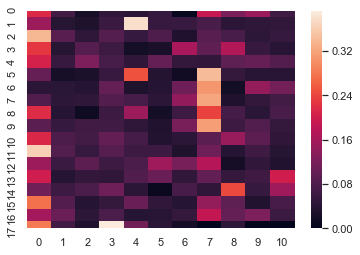

 video_shift index 0 at 04:06 , chapter title Introduction ( index 0) 
 video_shift index 1 at 06:55 , chapter title Sets ( index 4) 
 video_shift index 2 at 08:54 , chapter title Introduction ( index 0) 
 video_shift index 3 at 10:39 , chapter title Introduction ( index 0) 
 video_shift index 4 at 13:03 , chapter title Introduction ( index 0) 
 video_shift index 5 at 14:56 , chapter title Sorting ( index 7) 
 video_shift index 6 at 17:42 , chapter title Sorting ( index 7) 
 video_shift index 7 at 22:09 , chapter title Sorting ( index 7) 
 video_shift index 8 at 24:41 , chapter title Sorting ( index 7) 
 video_shift index 9 at 27:11 , chapter title Sorting ( index 7) 
 video_shift index 10 at 30:18 , chapter title Introduction ( index 0) 
 video_shift index 11 at 33:39 , chapter title Introduction ( index 0) 
 video_shift index 12 at 38:24 , chapter title Sorting ( index 7) 
 video_shift index 13 at 41:42 , chapter title Strings ( index 10) 
 video_shift index 14 at 45:20 , chapter tit

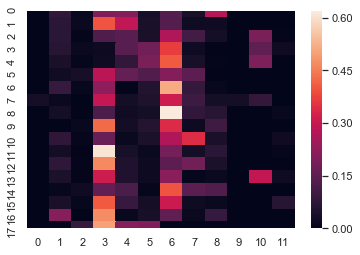

 video_shift index 0 at 04:06 , chapter title 1.5	Book outline ( index 8) 
 video_shift index 1 at 06:55 , chapter title 1.2.1	Big Oh notation ( index 3) 
 video_shift index 2 at 08:54 , chapter title 1.3	Pseudocode ( index 6) 
 video_shift index 3 at 10:39 , chapter title 1.3	Pseudocode ( index 6) 
 video_shift index 4 at 13:03 , chapter title 1.3	Pseudocode ( index 6) 
 video_shift index 5 at 14:56 , chapter title 1.2.1	Big Oh notation ( index 3) 
 video_shift index 6 at 17:42 , chapter title 1.3	Pseudocode ( index 6) 
 video_shift index 7 at 22:09 , chapter title 1.3	Pseudocode ( index 6) 
 video_shift index 8 at 24:41 , chapter title 1.3	Pseudocode ( index 6) 
 video_shift index 9 at 27:11 , chapter title 1.2.1	Big Oh notation ( index 3) 
 video_shift index 10 at 30:18 , chapter title 1.4	Tips for working through the examples ( index 7) 
 video_shift index 11 at 33:39 , chapter title 1.2.1	Big Oh notation ( index 3) 
 video_shift index 12 at 38:24 , chapter title 1.2.1	Big Oh notat

In [21]:
chapters_matching_topics = {}
#for vid in videos_ids:
for vid in [videos_ids[-1]]:
    print('################ %s ################' % (vid))
    paper_name = video_to_paper[vid]
    correlations_levels = []
    
    
    
    '''Finding the correlation between topic and main chapters'''
    main_matching_topic,correlation, tmp = get_topic_chapter_corr_tfidf(paper_name,
                                 paper_mains_as_one_doc[paper_name],
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 paper_content[paper_name]['main titles'])
    
    correlations_levels.append(correlation)
    #print(main_matching_topic)
    dominet_chapter =  find_dominent_main_chapter(main_matching_topic,
                                                  paper_content[paper_name]['main titles'],
                                                 correlation)
    print('By the majority vote, the dominent chapter choosed is %s ' %(dominet_chapter))
    
    #Searching for each topic the most correlated 
    #subsection to a topic within the dominent main chapter '''
    dom_main_cha_index = paper_content[paper_name]['main titles'].index(dominet_chapter)
    dom_subsec_text = [paper_subsec_as_one_doc[paper_name][s_i] for s_i in
                      paper_sec_within_main_indexes[paper_name][dom_main_cha_index]]
    dom_subsec_titles = [paper_content[paper_name]['titles'][tl]
                         for tl in paper_sec_within_main_indexes[paper_name][dom_main_cha_index]]
    
    dom_subsec_text = emphasize_title(paper_name,dom_subsec_text,
                                      dom_subsec_titles,lemmatizing = lemmatizing_method)
    
    subsec_matching_topic,correlation,df_results = get_topic_chapter_corr_tfidf(paper_name,
                                 dom_subsec_text,
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 dom_subsec_titles,
                                 to_df = True)
    
    correlations_levels.append(correlation)
    #measure_confidence(vid,correlations_levels)
    
    
    
    
    

In [22]:
df_google_form = pd.read_csv('../data/raw/forms/form-answers-poc.csv')
mycolumns = [
             '00:00-04:06','04:06-06:55','06:55-08:54',
             '08:54-10:39','10:39-13:03','13:03-14:56',
             '14:56-17:42','17:42-22:09','22:09-24:41',
             '24:41-27:11','27:11-30:18','30:18-33:39',
             '33:39-38:24','38:24-41:42','41:42-45:20',
             '45:20-49:47','49:47-52:52','52:52-53:30',
             'rating_00:00-04:06','rating_04:06-06:55','rating_06:55-08:54',
             'rating_08:54-10:39','rating_10:39-13:03','rating_13:03-14:56',
             'rating_14:56-17:42','rating_17:42-22:09','rating_22:09-24:41',
             'rating_24:41-27:11','rating_27:11-30:18','rating_30:18-33:39',
             'rating_33:39-38:24','rating_38:24-41:42','rating_41:42-45:20',
             'rating_45:20-49:47','rating_49:47-52:52','rating_52:52-53:30'
            ]
df_google_form = df_google_form.drop(columns=['מבין הפרקים הבאים, איזה אחד הכי מתאים לטווח הזמנים: 00:00-04:06 בסרטון'
                                              ,'חותמת זמן','Unnamed: 20'])
df_google_form.columns = mycolumns
df_google_form.columns

Index(['00:00-04:06', '04:06-06:55', '06:55-08:54', '08:54-10:39',
       '10:39-13:03', '13:03-14:56', '14:56-17:42', '17:42-22:09',
       '22:09-24:41', '24:41-27:11', '27:11-30:18', '30:18-33:39',
       '33:39-38:24', '38:24-41:42', '41:42-45:20', '45:20-49:47',
       '49:47-52:52', '52:52-53:30', 'rating_00:00-04:06',
       'rating_04:06-06:55', 'rating_06:55-08:54', 'rating_08:54-10:39',
       'rating_10:39-13:03', 'rating_13:03-14:56', 'rating_14:56-17:42',
       'rating_17:42-22:09', 'rating_22:09-24:41', 'rating_24:41-27:11',
       'rating_27:11-30:18', 'rating_30:18-33:39', 'rating_33:39-38:24',
       'rating_38:24-41:42', 'rating_41:42-45:20', 'rating_45:20-49:47',
       'rating_49:47-52:52', 'rating_52:52-53:30'],
      dtype='object')

In [23]:
df_google_form

,00:00-04:06,04:06-06:55,06:55-08:54,08:54-10:39,10:39-13:03,13:03-14:56,14:56-17:42,17:42-22:09,22:09-24:41,24:41-27:11,...,rating_22:09-24:41,rating_24:41-27:11,rating_27:11-30:18,rating_30:18-33:39,rating_33:39-38:24,rating_38:24-41:42,rating_41:42-45:20,rating_45:20-49:47,rating_49:47-52:52,rating_52:52-53:30
0,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.3 Pseudocode,1.3 Pseudocode,1.2.2 Imperative programming language,...,2,2,1,1,4,4,4,4,4,3
1,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.2.1 Big Oh notation,...,4,3,4,4,1,5,4,4,4,5
2,1.5 Book outline,1.2.1 Big Oh notation,1.6 Testing,1.3 Pseudocode,1.3 Pseudocode,1.6 Testing,1.3 Pseudocode,1.2.1 Big Oh notation,1.6 Testing,1.6 Testing,...,4,3,3,3,5,5,5,5,4,4
3,"1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t",1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,...,1,1,1,1,2,2,1,2,2,2
4,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.2.1 Big Oh notation,...,2,1,3,2,5,5,5,4,2,2
5,"1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t",1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.2.3. Object oriented concepts,1.3 Pseudocode,1.2.1 Big Oh notation,...,3,3,3,3,3,3,4,4,4,3
6,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.2.1 Big Oh notation,1.2.1 Big Oh notation,...,4,4,5,5,5,5,5,5,5,4
7,"1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t",1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.6 Testing,1.6 Testing,1.6 Testing,1.2.1 Big Oh notation,1.2.1 Big Oh notation,...,3,3,4,4,5,5,5,5,5,4


In [24]:
questions = list(filter(lambda x: "rating" not in x,df_google_form.columns))
rating_confidence = list(filter(lambda x: "rating" in x,df_google_form.columns))
chapters_most_frequent = [df_google_form[col].mode().values.tolist() for col in questions]
ratings_avg = [df_google_form[col].mean() for col in rating_confidence]
ratings_var = [df_google_form[col].var() for col in rating_confidence]
df_results['most corr labeled chapters'] = chapters_most_frequent
df_results['rating mean confidence '] = ratings_avg
df_results['rating var confidence '] = ratings_var
df_results['labeled num choices'] = [len(df_google_form[col].value_counts()) for col in questions]
df_results['max entropy'] = [np.log2(len(df_google_form[col].value_counts())) for col in questions]
df_results['labeled choose entropy'] = [entropy(df_google_form[col].value_counts(normalize=True),base=2) for col in questions]
df_results['founded chapter corr'] = [max(topic_correlations) for topic_correlations in correlation]
dom_subsec_titles_ = [re.sub("\t",' ',tl) for tl in dom_subsec_titles]
df_results['labeled chapter corr'] = [[correlation[index][dom_subsec_titles_.index(ch)] for ch in ch_corr_labeled] 
                                      for index,ch_corr_labeled in enumerate(chapters_most_frequent)]
df_results

,shift,most_correlated_chapter,most corr labeled chapters,rating mean confidence,rating var confidence,labeled num choices,max entropy,labeled choose entropy,founded chapter corr,labeled chapter corr
0,04:06,1.5\tBook outline,"[1.1 What this book is, and what it isn’t]",4.125,1.839286,2,1.000000,0.543564,0.279412,[0.0810320207246663]
1,06:55,1.2.1\tBig Oh notation,[1.2.1 Big Oh notation],3.125,1.839286,2,1.000000,0.954434,0.399531,[0.3995312850660362]
2,08:54,1.3\tPseudocode,[1.3 Pseudocode],4.000,1.714286,4,2.000000,1.905639,0.270121,[0.2701205074530006]
3,10:39,1.3\tPseudocode,[1.3 Pseudocode],2.750,1.642857,1,0.000000,0.000000,0.369668,[0.3696675571670164]
4,13:03,1.3\tPseudocode,[1.3 Pseudocode],3.250,1.642857,1,0.000000,0.000000,0.405882,[0.40588182540371864]
5,14:56,1.2.1\tBig Oh notation,"[1.3 Pseudocode, 1.4 Tips for working through ...",4.125,0.982143,3,1.584963,1.561278,0.284089,"[0.20769615576973, 0.14821703565794753]"
6,17:42,1.3\tPseudocode,[1.3 Pseudocode],3.375,1.982143,3,1.584963,1.405639,0.517513,[0.5175131791072759]
7,22:09,1.3\tPseudocode,[1.4 Tips for working through the examples],3.000,1.714286,5,2.321928,2.155639,0.314325,[0.09764649601302315]
8,24:41,1.3\tPseudocode,[1.4 Tips for working through the examples],2.875,1.267857,4,2.000000,1.905639,0.620067,[0.0814648555802603]
9,27:11,1.2.1\tBig Oh notation,[1.2.1 Big Oh notation],2.500,1.142857,4,2.000000,1.548795,0.428577,[0.42857667355730433]


In [25]:
hit = 0
miss = 0
for index, row in df_results.iterrows():
    founded_ch = row['most_correlated_chapter']
    labeled_chapters = row['most corr labeled chapters']
    founded_ch = re.sub('\t',' ', founded_ch)
    #col_range_correct = df_google_form.columns[index] + ""
    if founded_ch in labeled_chapters:
        hit+=1
        df_results.loc[index,'range_correct'] = df_google_form.columns[index] + " (HIT)"
    else:
        df_results.loc[index,'range_correct'] = df_google_form.columns[index] + " (MISS)"
        print('miss in %s ' %(index))
        miss+=1
print("hit: %d miss: %s hit ratio: %f" %(hit,miss,hit/(hit+miss)))
df_results['range_correct']

miss in 0 
miss in 5 
miss in 7 
miss in 8 
miss in 10 
miss in 14 
miss in 17 
hit: 11 miss: 7 hit ratio: 0.611111


0     00:00-04:06 (MISS)
1      04:06-06:55 (HIT)
2      06:55-08:54 (HIT)
3      08:54-10:39 (HIT)
4      10:39-13:03 (HIT)
5     13:03-14:56 (MISS)
6      14:56-17:42 (HIT)
7     17:42-22:09 (MISS)
8     22:09-24:41 (MISS)
9      24:41-27:11 (HIT)
10    27:11-30:18 (MISS)
11     30:18-33:39 (HIT)
12     33:39-38:24 (HIT)
13     38:24-41:42 (HIT)
14    41:42-45:20 (MISS)
15     45:20-49:47 (HIT)
16     49:47-52:52 (HIT)
17    52:52-53:30 (MISS)
Name: range_correct, dtype: object

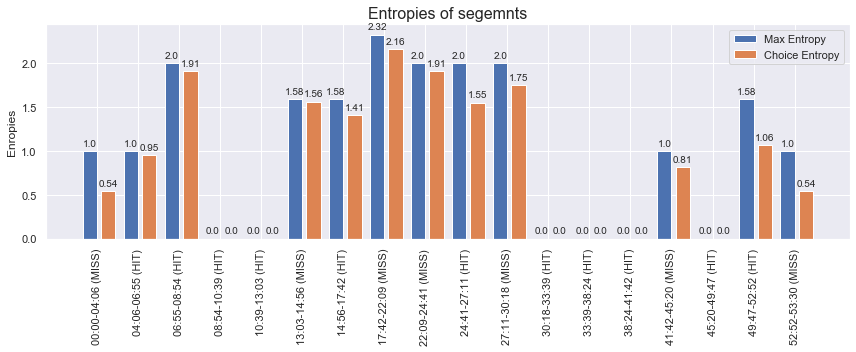

In [26]:


labels = df_results['range_correct'].values.tolist()
max_entropy = df_results['max entropy'].values.tolist()
choice_entropy = df_results['labeled choose entropy'].values.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width/2, max_entropy, width, label='Max Entropy')
rects2 = ax.bar(x + width/2 + 0.1, choice_entropy, width, label='Choice Entropy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Enropies')
ax.set_title('Entropies of segemnts',fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation = 90)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
#fig.figsize = (100,100)



plt.show()

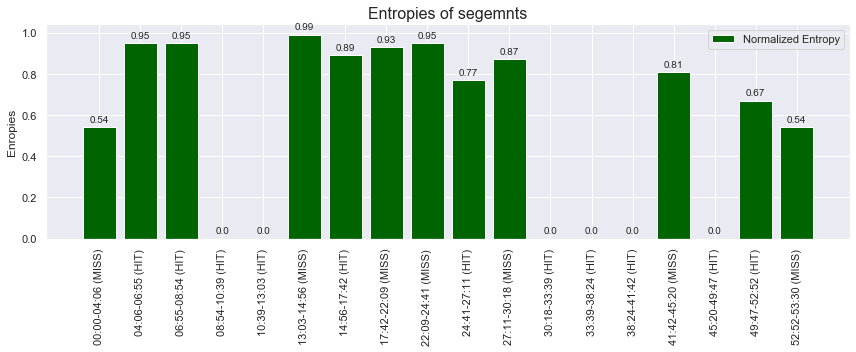

In [30]:
labels = df_results['range_correct'].values.tolist()
max_entropy = df_results['max entropy'].values.tolist()
choice_entropy = df_results['labeled choose entropy'].values.tolist()
epsilon = 0.00001
normalized_entropy = list(map(lambda x,y: round(x/(y + epsilon),2),choice_entropy,max_entropy))
x = np.arange(len(labels))  # the label locations
#width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,5))
rects=  ax.bar(x, normalized_entropy, label='Normalized Entropy',color='darkgreen')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Enropies')
ax.set_title('Entropies of segemnts',fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation = 90)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects)

fig.tight_layout()
#fig.figsize = (100,100)



plt.show()

miss in 0 
miss in 5 
miss in 7 
miss in 8 
miss in 10 
miss in 14 
miss in 17 
hit: 11 miss: 7 hit ratio: 0.611111
